### Hypothesis of oversold levels and increased volumes
#### Created 22.02.21
---

*Oversold levels defined as the difference between buy and sell volumes at the given price level*

The trading logic is

<ol>
<li>use 1-hour time frame</li>
<li>look at the difference between volumes</li>
<li>look if you are in the oversold territory</li>
<li>if 2 and 3 are true then buy</li>
</ol>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [2]:
df = pd.read_csv('GAZP_181201_201201_hour.csv')

In [3]:
df.head()

,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL
0,20181203,110000,164.20,166.50,164.01,165.71,8836150
1,20181203,120000,165.71,165.83,163.81,165.40,6750400
2,20181203,130000,165.47,165.88,164.35,164.49,2741060
3,20181203,140000,164.54,164.63,163.81,163.94,2158530
4,20181203,150000,163.95,164.77,163.87,164.44,1765830


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5088 entries, 0 to 5087
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    5088 non-null   int64  
 1   TIME    5088 non-null   int64  
 2   OPEN    5088 non-null   float64
 3   HIGH    5088 non-null   float64
 4   LOW     5088 non-null   float64
 5   CLOSE   5088 non-null   float64
 6   VOL     5088 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 278.4 KB
The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


In [5]:
#explanatory
df['direction'] = df.apply(lambda x: -1 if x['OPEN']>x['CLOSE'] else 1, axis  =1)
df_1 = df.groupby([df['CLOSE'].round(0), df['direction']])['VOL'].sum().to_frame()
df_1 = df_1.unstack(1)
df_1.head()

VOL            
direction          -1           1
CLOSE                            
146.0       7044870.0         NaN
147.0       2456020.0   3663990.0
148.0        818760.0   1451750.0
149.0      19410600.0   5864500.0
150.0      36428970.0  27705820.0

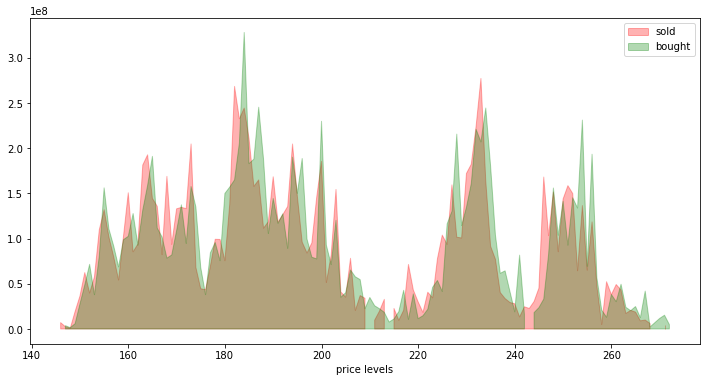

In [6]:
plt.figure(figsize= (12,6))
plt.fill_between(df_1.index, df_1.iloc[:,0], alpha=0.3, color= 'red', label = 'sold')
plt.fill_between(df_1.index, df_1.iloc[:,1], alpha=0.3, color= 'green', label = 'bought')
plt.legend()
plt.xlabel('price levels')
plt.show()

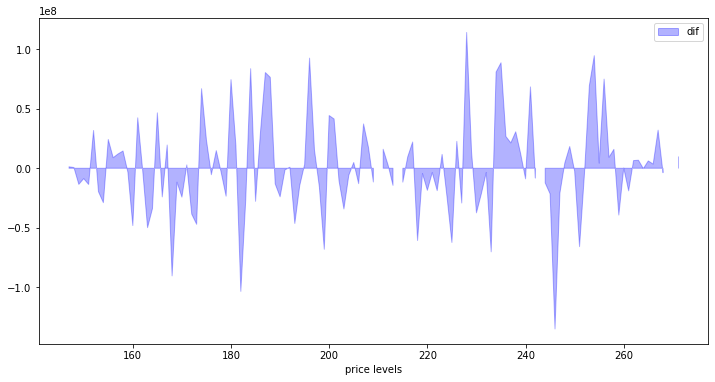

In [7]:
plt.figure(figsize= (12,6))
plt.fill_between(df_1.index, df_1.iloc[:,1] - df_1.iloc[:,0], alpha=0.3, color= 'blue', label = 'dif')
plt.legend()
plt.xlabel('price levels')
plt.show()

In [8]:
i = 0
action_dic = {} # open or not a position
margin = 2 # the difference between two volumes
end = df.shape[0]//100-10
while True:
    df_temp = df.iloc[0:1000+100*i]
    # group and stack
    df_temp['direction'] = df_temp.apply(lambda x: -1 if x['OPEN']>x['CLOSE'] else 1, axis  =1)
    df1 = df_temp.groupby([df_temp['CLOSE'].round(0), df_temp['direction']])['VOL'].sum().to_frame()
    df2 = df1.unstack(1)
    df2.columns = ['down', 'up']
    df2['dif']=df2['up']-df2['down']
    for j in range(100):
        step = 1000+100*(i-1)+j
        # if (vol_t>2*vol_t-1) and oversold: dif[price_t]<0
        if (df_temp['VOL'].iloc[step]>df_temp['VOL'].iloc[step-1]*margin) and (df2.loc[df_temp['CLOSE'].iloc[step].round(0)]['dif']<0):
            action_dic[step]=1
        else:
            action_dic[step]=0
    i+=1
    if i>=end:
        break


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


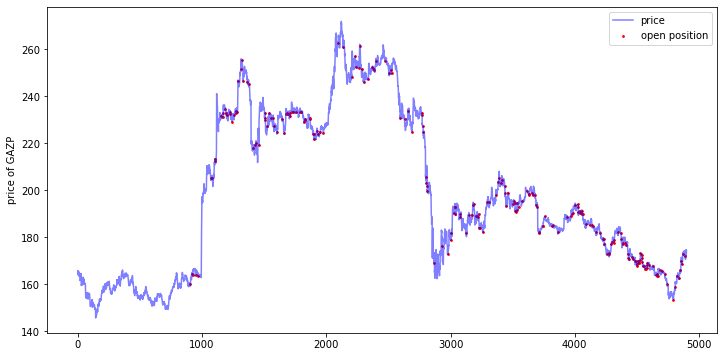

In [9]:
position = []    
for key, value in action_dic.items():
    if value == 1:
        position.append(key)
        
_ = plt.figure(figsize= [12,6])
_ = plt.plot(df_temp['CLOSE'], color = 'blue', alpha=0.5, label = 'price')
_ = plt.scatter(position, df_temp['CLOSE'].iloc[position], color = 'red', s=3, label = 'open position')
plt.ylabel('price of GAZP')
plt.legend()
plt.show()

In [10]:
low_margin = 0.95 #close position if lose 5%
high_margin = 1.05 #close position if earn 5%
actions_dic = {} #dic with info about results of trading 
action_dic_2 = {} #type of closing
period = 12 # max period of holding
prev_pos = 0 #remove overlapping

for pos in position[:-2]:
    if pos < prev_pos:
        continue
    else:
        for j in range(period):
            if df['CLOSE'].iloc[pos+j]<low_margin*df['CLOSE'].iloc[pos]:
                action_dic_2[pos] = -1
                actions_dic[pos] = (df['CLOSE'].iloc[pos+j]/df['CLOSE'].iloc[pos])
                prev_pos = pos+j
                break
            elif df['CLOSE'].iloc[pos+j]>high_margin*df['CLOSE'].iloc[pos]:
                action_dic_2[pos] = 1
                actions_dic[pos] = (df['CLOSE'].iloc[pos+j]/df['CLOSE'].iloc[pos])
                prev_pos = pos+j
                break
            elif j==period-1:
                action_dic_2[pos] = 0
                actions_dic[pos] = (df['CLOSE'].iloc[pos+j]/df['CLOSE'].iloc[pos])
                prev_pos = pos+j
                break
            else:
                pass
        
val_0 = 1 #initial portfolio
list_p = [] #portfolio path
for val in actions_dic.values():
    val_0=val_0*val
    list_p.append(val_0)

In [11]:
val_0

1.260338510593596

In [12]:
np.std(list_p)

0.08546786258028383

In [13]:
list_p.insert(0,1)

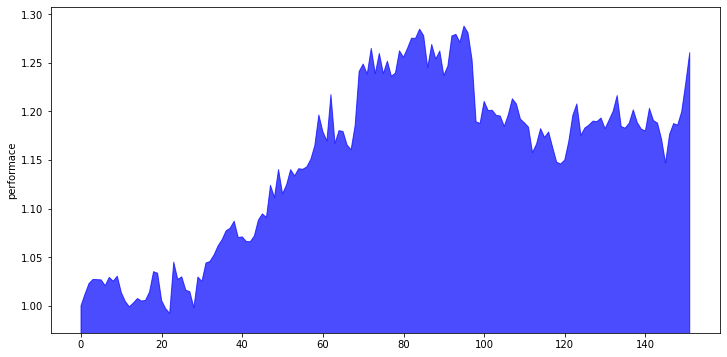

In [14]:
plt.figure(figsize= (12,6))
plt.fill_between(range(len(list_p)), list_p, alpha = 0.7, color = 'blue')
plt.ylabel('performace')
plt.ylim(np.min(list_p)-0.02,np.max(list_p)+0.02)
plt.show()

In [15]:
# number of deals
Counter(action_dic_2.values())

Counter({0: 149, 1: 1, -1: 1})

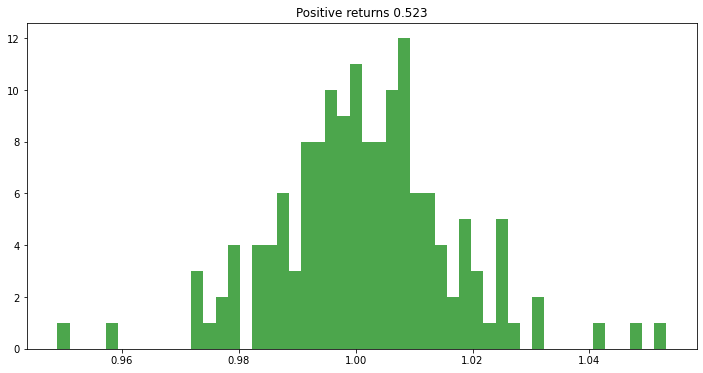

In [16]:
number = np.sum([1 if x>1 else 0 for x in actions_dic.values()])/len(actions_dic.values())

_ = plt.figure(figsize=(12,6))
_ = plt.hist(actions_dic.values(), bins= 50, color = 'green', alpha= 0.7)
plt.title('Positive returns {:.3f}'.format(number))
plt.show();